In [1]:
import pandas as pd
import geopandas as gpd
import geobr
import plotly.express as px
import re
import os

In [2]:
file_path = 'data/processed/agg_data.csv'

if os.path.exists(file_path):
    
    # read data
    concluintes = pd.read_csv('data/processed/agg_data.csv')
else:
    
    # read data
    df = pd.read_csv('data/raw/MICRODADOS_CADASTRO_CURSOS_2022.CSV', sep=';', encoding='ISO-8859-1', dtype={
        'NU_ANO_CENSO': 'string',
        'CO_REGIAO': 'string',
        'CO_UF': 'string',
        'NO_UF': 'string',
        'NO_MUNICIPIO': 'string'
    })
    cols = ['NU_ANO_CENSO', 'NO_UF', 'SG_UF', 'NO_MUNICIPIO', 'CO_MUNICIPIO', 'NO_CURSO', 'QT_CONC',
            'QT_CONC_FEM', 'QT_CONC_MASC', 'QT_CONC_BRANCA', 'QT_CONC_PRETA', 'QT_CONC_PARDA', 'QT_CONC_AMARELA',
            'QT_CONC_INDIGENA', 'QT_CONC_CORND']

    

    # filter data
    df = df[cols][df['SG_UF'] == 'SP']
    eng_mec = df[df['NO_CURSO'].str.contains('(Mecânica)') & df['NO_CURSO'].str.contains('(Engenharia)')]

    
    # aggregate data
    concluintes = eng_mec.groupby('CO_MUNICIPIO').agg({
        'QT_CONC': 'sum',
        'QT_CONC_FEM': 'sum',
        'QT_CONC_MASC': 'sum'
    }).reset_index()

    concluintes = concluintes[concluintes['QT_CONC'] >= 1]
    concluintes['% CONC_FEM'] = round((concluintes['QT_CONC_FEM'] / concluintes['QT_CONC'] * 100).fillna(0), 2)


    # write data
    concluintes.to_csv('data/processed/agg_data.csv', index=False)


In [3]:
cities = geobr.read_municipality(code_muni='SP', year=2022)
concluintes = concluintes.merge(right=cities, how = 'left', left_on = 'CO_MUNICIPIO', right_on = 'code_muni')

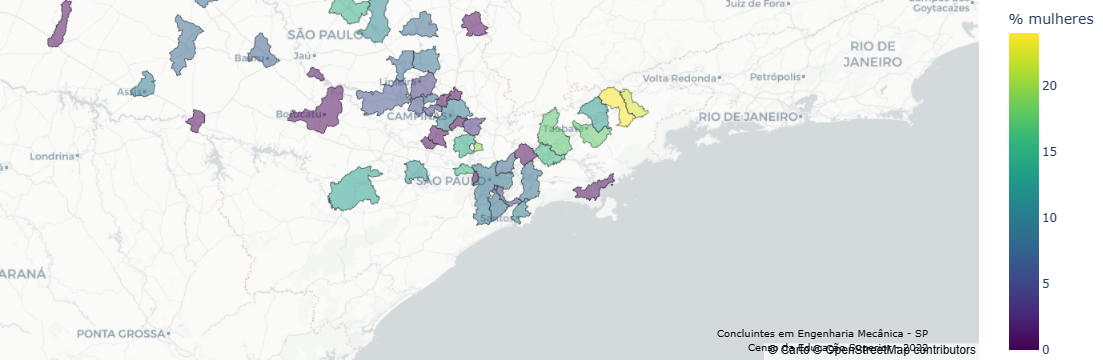

In [7]:
gdf = gpd.GeoDataFrame(concluintes, geometry='geometry')
fig = px.choropleth_mapbox(data_frame=gdf,
                           geojson=gdf.geometry,
                           locations=gdf.index,
                           hover_name='name_muni',  # Specify the column to display on hover
                           hover_data={'QT_CONC': True, 'QT_CONC_FEM': True, 'QT_CONC_MASC': True, '% CONC_FEM' : True},
                           color='% CONC_FEM',  # Specify the column to use for coloring
                           color_continuous_scale='Viridis',  # Or any other color scale
                           mapbox_style="carto-positron",
                           center={"lat": -23.5505, "lon": -46.6333},  # Center of the map
                           zoom=6,  # Zoom level of the map
                           opacity=0.5,  # Opacity of the map
                           labels={'% CONC_FEM': '% mulheres',
                                   'QT_CONC': '# concluintes',
                                   'QT_CONC_FEM': '# feminino',
                                   'QT_CONC_MASC': '# masculino'}
                           )

fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0},  # Adjust layout margin
                  annotations=[
                      dict(
                          text="Censo da Educação Superior - 2022",  # Add your subtitle here
                          x=0.95,
                          y=0.01,
                          xref="paper",
                          yref="paper",
                          showarrow=False,
                          font=dict(size=10, color="black")
                      ),
                  
                      dict(
                          text="Concluintes em Engenharia Mecânica - SP",  # Add your subtitle here
                          x=0.95,
                          y=0.05,
                          xref="paper",
                          yref="paper",
                          showarrow=False,
                          font=dict(size=10, color="black")
                      )]
                 ) 
fig.show()
